In [1]:
machine = 'mac'
machine = 'magny'

In [2]:
from galpy.potential import NFWPotential as NFWpot
from galpy.potential import HernquistPotential as HEpot
from galpy.potential import DoubleExponentialDiskPotential as DEpot
from galpy.potential import MiyamotoNagaiPotential as MNpot
from galpy.potential import MN3ExponentialDiskPotential as MN3pot
from galpy.potential import MWPotential2014

from galpy.potential import evaluateDensities, evaluatePotentials
from galpy.potential import plotDensities
from galpy.potential import plotRotcurve
from galpy.util import bovy_conversion

import numpy as np
from scipy import optimize as opt

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import copy

from areposnap.gadget import gadget_readsnap
from areposnap.gadget_subfind import load_subfind
import calcGrid

from auriga_basics import *
from auriga_functions import *

%matplotlib inline

In [3]:
#### path = /hits/universe/GigaGalaxy/level4_MHD/halo_24/output/*
level = 4
if machine == 'magny':
    basedir = "/hits/universe/GigaGalaxy/level4_MHD/"
elif machine == 'mac': 
    basedir = "/Users/smilanov/Desktop/Auriga/level4/"
j = 0
for halo_number in [24]:  # range(1, 31):
    halodir = basedir+"halo_{0}/".format(halo_number)
    snappath = halodir+"output/"
    for snapnr in range(127,128,1):
        print("level   : {0}".format(level))
        print("halo    : {0}".format(halo_number))
        print("snapnr  : {0}".format(snapnr))
        print("basedir : {0}".format(basedir))
        print("halodir : {0}".format(halodir))
        print("snappath: {0}\n".format(snappath))
        s, sf = eat_snap_and_fof(level, halo_number, snapnr, snappath, loadonlytype=[0,1,2,3,4,5], 
            haloid=0, galradfac=0.1, verbose=True) 

        # Clean negative and zero values of gmet to avoid RuntimeErrors
        # later on (e.g. dividing by zero)
        s.data['gmet'] = np.maximum( s.data['gmet'], 1e-40 )
     

level   : 4
halo    : 24
snapnr  : 127
basedir : /hits/universe/GigaGalaxy/level4_MHD/
halodir : /hits/universe/GigaGalaxy/level4_MHD/halo_24/
snappath: /hits/universe/GigaGalaxy/level4_MHD/halo_24/output/

[ 34.42281723  33.16259384  37.29567337]
Found 1783163 stars.
Rotated pos.
Rotated bfld.
Rotated vel.

galrad  : 0.02408556640148163
redshift: 2.220446049250313e-16
time    : 0.9999999999999998
center  : [ 0.  0.  0.]



In [11]:
#maxr = s.galrad
maxr = 0.015 #Mpc
iall, = np.where( (s.halo == 0) & (s.r() < maxr) & (s.r() > 0.) )
igas, = np.where( (s.halo == 0) & (s.r() < maxr) & (s.r() > 0.) & (s.type == 0) )
idm, = np.where( (s.halo == 0) & (s.r() < maxr) & (s.r() > 0.) & ((s.type == 1) + (s.type == 2) + (s.type == 3) ))
istars, = np.where( (s.halo == 0) & (s.r() < maxr) & (s.r() > 0.) & (s.type == 4) )
mask = iall    

(x_kpc, y_kpc, z_kpc), (vx_kms, vy_kms, vz_kms), rxyz_kpc, rxy_kpc = get_cartesian_vectors(s, sf, mask)
(R_kpc, phi, z_kpc), (vR_kms, vphi, vz_kms) = get_cylindrical_vectors(s, sf, mask)


(x, y, z), (vx, vy, vz), rxyz, rxy = get_cartesian_vectors(s, sf, mask)
(R, phi, z), (vR, vphi, vz) = get_cylindrical_vectors(s, sf, mask)


201.142


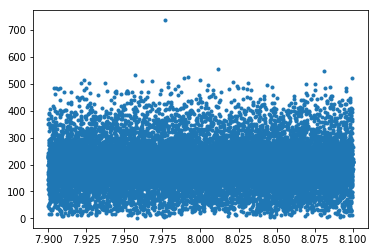

In [16]:
v_circ = np.sqrt(vx**2 + vy**2)
r_select = np.where((rxy >7.9) & (rxy <8.1))
plt.plot(rxy[r_select], v_circ[r_select],'.')
print(np.mean(v_circ[r_select]))

/home/extmilan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: PyArray_FromDims: use PyArray_SimpleNew.
  """Entry point for launching an IPython kernel.

/home/extmilan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: PyArray_FromDimsAndDataAndDescr: use PyArray_NewFromDescr.
  """Entry point for launching an IPython kernel.

[  0.22408369   0.67225106   1.12041844   1.56858581   2.01675319
   2.46492057   2.91308794   3.36125532   3.80942269   4.25759007
   4.70575744   5.15392482   5.60209219   6.05025957   6.49842694
   6.94659432   7.3947617    7.84292907   8.29109645   8.73926382
   9.1874312    9.63559857  10.08376595  10.53193332  10.9801007
  11.42826807  11.87643545  12.32460283  12.7727702   13.22093758
  13.66910495  14.11727233  14.5654397   15.01360708  15.46177445
  15.90994183  16.3581092   16.80627658  17.25444396  17.70261133
  18.15077871  18.59894608  19.04711346  19.49528083  19.94344821
  20.3916

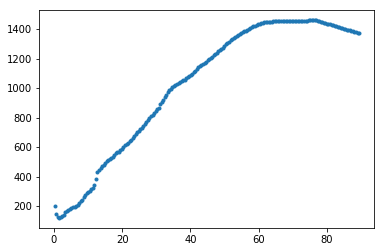

In [4]:
masses, radius = calcGrid.calcRadialProfile(s.pos.astype('float'), s.data['mass'].astype('float'), 0)
print(radius)
mass_cum = np.cumsum(masses)
vrot = np.sqrt(43.0071 * mass_cum/ (radius)) 
plt.plot(radius, vrot, '.', label  = 'mode 0')

In [ ]:
masses, radius = calcGrid.calcRadialProfile(s.pos.astype('float'), s.data['mass'].astype('float'), 1)
mass_cum = np.cumsum(masses)
vrot = np.sqrt(43.0071 * mass_cum / (radius)) 
plt.plot(radius, vrot, '.', label  = 'mode 1')
masses, radius = calcGrid.calcRadialProfile(s.pos.astype('float'), s.data['mass'].astype('float'), 2)
mass_cum = np.cumsum(masses)
vrot = np.sqrt(43.0071 * mass_cum / (radius)) 
plt.plot(radius, vrot, '.', label  = 'mode 2')
masses, radius = calcGrid.calcRadialProfile(s.pos.astype('float'), s.data['mass'].astype('float'), 3)
mass_cum = np.cumsum(masses)
vrot = np.sqrt(43.0071 * mass_cum / (radius)) 
plt.plot(radius, vrot, '.', label  = 'mode 3')
plt.legend()

In [ ]:
# from The GigaGalaxy Project (analysis tool) / galaxy / plot_rotcurve_multi.py
subhalo = 0
s.center = sf.data['fpos'][subhalo,:]

pos = s.data['pos'].astype('float64')
mass = s.data['mass'].astype('float64')

nshells = 200
radius = 90
dr = radius / nshells

na = s.nparticlesall
end = na.copy()
end[1:] += end[:-1]
start = np.zeros(len(na), dtype='int32')
start[1:] = end[:-1]

shmass = np.zeros( (nshells, 1) )
shvel = np.zeros( (nshells, 1) )
vtot = np.zeros(nshells)

print(start)
print(end)
for i in range( 1 ):
    rp = calcGrid.calcRadialProfile( s.pos.astype('float64'), s.data['mass'].astype('float64'), 0, nshells, dr, s.center[0], s.center[1], s.center[2] )
    print(rp)
    radius = rp[1,:]
    shmass[:,i] = rp[0,:]
    for j in range( 1, nshells ):
        shmass[j,i] += shmass[j-1,i]
    shvel[:,i] = np.sqrt( 43.0071 * shmass[:,i] / (radius) )
    vtot[:] += (shvel[:,i]**2)



In [ ]:
print(rp)
plt.plot(radius, vtot, '.')


In [ ]:
test = calcGrid.calcRadialProfile( s.pos.astype('float64'), s.data['mass'].astype('float64'))

In [ ]:
G = 43.0071 # in Mpc / (10^10 M_sun) * (km/s)^2
radius = test[1,:]
shmass = test[0,:]
for j in range( len(test[0]) ):
    shmass[j] += shmass[j-1]
vtot = np.sqrt(43.0071 * shmass / (radius)) 
print(test, vtot)

In [ ]:
plt.plot(test[1,:], vtot, '.')
#plt.xlim(0,80)

In [ ]:
# find circular velocity in outskirts
# from The GigaGalaxy Project (analysis tool) / galaxy / plot_rotcurve_multi.py
s.center = sf.data['fpos'][subhalo,:]

pos = s.data['pos'].astype('float64')
mass = s.data['mass'].astype('float64')

nshells = 100
radius = 0.04
dr = radius / nshells

na = s.nparticlesall
end = na.copy()
end[1:] += end[:-1]
start = np.zeros(len(na), dtype='int32')
start[1:] = end[:-1]

shmass = np.zeros( (nshells, 6) )
shvel = np.zeros( (nshells, 6) )
vtot = np.zeros(nshells)
for i in range( 6 ):
    rp = calcGrid.calcRadialProfile( s.pos[start[i]:end[i],:].astype('float64'), s.data['mass'][start[i]:end[i]].astype('float64'), 0, nshells, dr, s.center[0], s.center[1], s.center[2] )

    radius = rp[1,:]
    shmass[:,i] = rp[0,:]
    for j in range( 1, nshells ):
        shmass[j,i] += shmass[j-1,i]
    shvel[:,i] = np.sqrt( 43.0071 * shmass[:,i] / (radius) )
    vtot[:] += (shvel[:,i]**2)



In [22]:
print(vtot)

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


In [23]:
print(rp)

[[ 0.      0.      0.      0.      0.      0.      0.      0.      0.      0.
   0.      0.      0.      0.      0.      0.      0.      0.      0.      0.
   0.      0.      0.      0.      0.      0.      0.      0.      0.      0.
   0.      0.      0.      0.      0.      0.      0.      0.      0.      0.
   0.      0.      0.      0.      0.      0.      0.      0.      0.      0.
   0.      0.      0.      0.      0.      0.      0.      0.      0.      0.
   0.      0.      0.      0.      0.      0.      0.      0.      0.      0.
   0.      0.      0.      0.      0.      0.      0.      0.      0.      0.
   0.      0.      0.      0.      0.      0.      0.      0.      0.      0.
   0.      0.      0.      0.      0.      0.      0.      0.      0.      0.    ]
 [ 0.0002  0.0006  0.001   0.0014  0.0018  0.0022  0.0026  0.003   0.0034
   0.0038  0.0042  0.0046  0.005   0.0054  0.0058  0.0062  0.0066  0.007
   0.0074  0.0078  0.0082  0.0086  0.009   0.0094  0.0098  0.0102  0

In [26]:
calcGrid.calcRadialProfile()

TypeError: calcRadialProfile( pos, data, mode, nshells, dr, centerx, centery, centerz )() takes at least 2 arguments (0 given)